## Main code to download images

In [7]:
#Import requirements
from bs4 import BeautifulSoup
import urllib
import wget
import re
from robobrowser import RoboBrowser
import pandas as pd


## 1. Read tables from CRTS of all the objects

In [2]:
df_light_curves.head() #muestra la tabla
ra_col = df_light_curves['ra']
dec_col = df_light_curves['dec']
for index, row in df_light_curves.iterrows():
    #x = np.array([row['ra'], row['dec']])
    ra_coord = row['ra']
    dec_coord = row['dec']
    str_query = str(ra_coord) + ' ' + str(dec_coord) #input para buscar


NameError: name 'df_light_curves' is not defined

## 2. Query search on Data Release 3

In [8]:
CRTS_DR3_beta_url = 'http://crts.iucaa.in/crts/'
DR3 = urllib.request.urlopen(CRTS_DR3_beta_url).read()
soup_DR3 = BeautifulSoup(DR3, "lxml")
print(type(soup_DR3))

<class 'bs4.BeautifulSoup'>


In [58]:
#Define subsample of objects for each class
list_of_classes = []
list_of_crds = []
#### CSS telescope ####
#SN: 
str_of_crds = '142.63453' + ' ' + '20.60814'
list_of_crds.append(str_of_crds)
object_class = 'SN'
list_of_classes.append(object_class)
#CV:
str_of_crds = '157.35429' + ' ' + '61.47645'
list_of_crds.append(str_of_crds)
object_class = 'CV'
list_of_classes.append(object_class)
#BZ:
str_of_crds = '342.49855' + ' ' + '-12.85467'
list_of_crds.append(str_of_crds)
object_class = 'BZ'
list_of_classes.append(object_class)
#AGN:
str_of_crds = '24.14416' + ' ' + '19.57569'
list_of_crds.append(str_of_crds)
object_class = 'AGN'
list_of_classes.append(object_class)
#FLARES:
str_of_crds = '352.68174' + ' ' + '14.08518'
list_of_crds.append(str_of_crds)
object_class = 'FLARES'
list_of_classes.append(object_class)
#OTHER: 
str_of_crds = '80.22595' + ' ' + '21.99364'
list_of_crds.append(str_of_crds)
object_class = 'OTHER'
list_of_classes.append(object_class)
print(list_of_classes, list_of_crds)

['SN', 'CV', 'BZ', 'AGN', 'FLARES', 'OTHER'] ['142.63453 20.60814', '157.35429 61.47645', '342.49855 -12.85467', '24.14416 19.57569', '352.68174 14.08518', '80.22595 21.99364']


In [63]:
#do this for each TO
browser = RoboBrowser()
browser.open(CRTS_DR3_beta_url)
form = browser.get_form(action='/crts/imaging')
# print(form)
def download_images_per_object (list_of_crds):
    form['imaging-search-query'].value = '332.64277 -22.66323' #'X' + ' ' + 'Y'
    form['imaging-search-radius'].value = '0.1'
    browser.submit_form(form) 
    #search: se actualiza la variable de browser 
    #duda: hay una forma de pedir la nueva url de esa pagina?

    #Find all the "values" or images for that object
    num = browser.find("div", {"class" : "Found"})
    complete_string = num.getText()
    total = [int(s) for s in complete_string.split() if s.isdigit()] #extraer el numero que corresponde a las ims
    list_of_numbers = list(range(0, int(total[0])-1))
    str_list_values = []
    for i in range(int(total[0])):
        a = i
        str_list_values.append(str(a))
    
    #extract information from the table
    #browser_html_code = browser.parsed() #type: <class 'bs4.element.ResultSet'>
    #first_element = browser_html_code[0] #type: <class 'bs4.element.Tag'>
    #text = first_element.getText()

    #x = browser.find("div", {"id" : "outTable"})
    #select only the table 
    read_table = browser.find("table", {"class" : "sortable"})  #type: <class 'bs4.element.Tag'>
    string_all_rows_table = read_table.getText()
    #print('what I found:', string_all_rows_table)
    list_all_rows_table = string_all_rows_table.strip().split()
    data_information = list_all_rows_table[4:]
    #extract info from each column
    center_ra_list = data_information[::4]
    center_dec_list = data_information[1::4] 
    obs_date_list = data_information[2::4]
    file_name_list = data_information[3::4]
    #create dataframe
    data = {list_all_rows_table[0] : center_ra_list, list_all_rows_table[1] : center_dec_list, 
        list_all_rows_table[2] : obs_date_list, list_all_rows_table[3] : file_name_list}
    df_per_object = pd.DataFrame(data)
    df_per_object.head()
    #print('html code:', browser.parsed()) #lo que está viendo de html

    #Proceed to download all the images of the object 
    print('*************')
    new_form = browser.get_form(action='/crts/download')
    print(new_form)
    # image = browser.get_form(class_='imaging-search-query')
    #print(image)
    # extraer todos los values con browser.find

    #new_form['downloadSelector'] = ['49','2'] #chulear el que tenga ese value
    new_form['downloadSelector'] = str_list_values
    browser.submit_form(new_form) #queda con un click here to download/se actualiza la pagina

    #se abre otra pagina
    link =browser.find("a", { "class" : "downloadLink" })
    download_zip = link.get('href')
    base_url = 'http://crts.iucaa.in'
    download_zip = base_url + download_zip
    out_dir = '/home/oem/Documentos/Astronomy/CRTS/Data/'
    complete_path = out_dir + object_class + '/'
    file_name = 'first_object.zip'
    wget.download(download_zip, complete_path + file_name)
    #print(download_zip)
    #save DF file with metadata
    #df_per_object.to_pickle(complete_path + file_name[0:-4] + '/' + file_name[0:-4] + '.pkl')
    df_per_object.to_pickle(complete_path + file_name[0:-4] + '.pkl')

 

/home/oem/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/oem/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [64]:
cont = 0
for object_class in list_of_classes:
    download_images_per_object(list_of_crds[cont])
    cont = cont + 1

/home/oem/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/oem/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


*************
<RoboForm resultsTable=/opt/www/crtsDR3/crtsDR3/staging/im332p64277_-22p66323_0p1_011144849797.dat, ra=332.64277, dec=-22.66323, radius=0.1, imageType=CutOuts, downloadSelector=[]>
*************
<RoboForm resultsTable=/opt/www/crtsDR3/crtsDR3/staging/im332p64277_-22p66323_0p1_011156921740.dat, ra=332.64277, dec=-22.66323, radius=0.1, imageType=CutOuts, downloadSelector=[]>
*************
<RoboForm resultsTable=/opt/www/crtsDR3/crtsDR3/staging/im332p64277_-22p66323_0p1_011208292894.dat, ra=332.64277, dec=-22.66323, radius=0.1, imageType=CutOuts, downloadSelector=[]>
*************
<RoboForm resultsTable=/opt/www/crtsDR3/crtsDR3/staging/im332p64277_-22p66323_0p1_011219626825.dat, ra=332.64277, dec=-22.66323, radius=0.1, imageType=CutOuts, downloadSelector=[]>
*************
<RoboForm resultsTable=/opt/www/crtsDR3/crtsDR3/staging/im332p64277_-22p66323_0p1_011230566693.dat, ra=332.64277, dec=-22.66323, radius=0.1, imageType=CutOuts, downloadSelector=[]>
*************
<RoboForm r

## 3. Read fits images

In [11]:
from astropy.io import fits
from astropy import wcs
import sys
import os
import glob
import cv2
import gzip
import numpy as np
import pandas as pd
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings("ignore")

Pixel coordinates: [[ 59.98307669  60.00845027]]


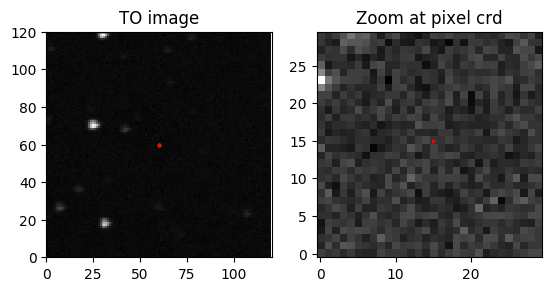

Pixel coordinates: [[ 60.02156108  70.00635594]]


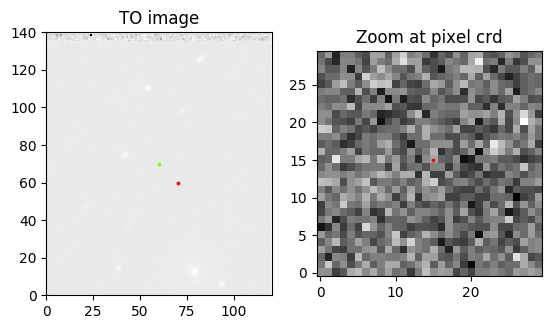

Pixel coordinates: [[ 60.02156052  70.00635959]]


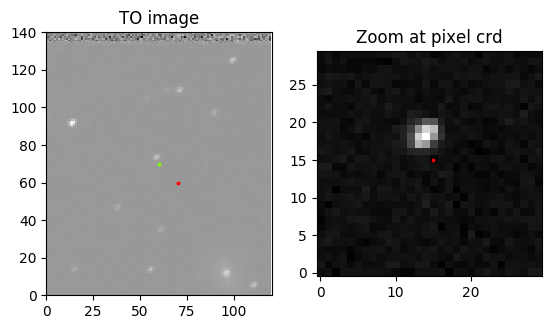

Pixel coordinates: [[ 60.02156075  70.00636252]]


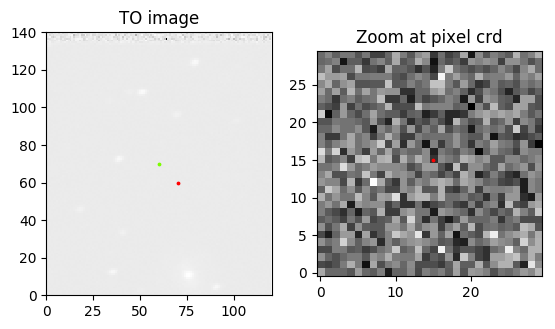

Pixel coordinates: [[ 60.0183369   60.00704053]]


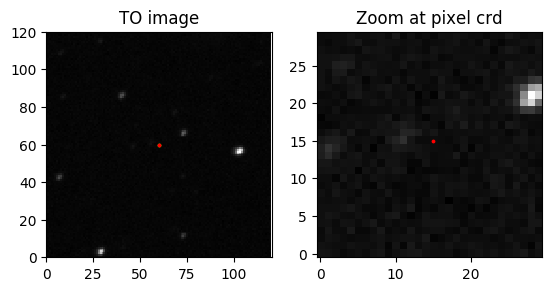

Pixel coordinates: [[ 60.02155867  70.00636627]]


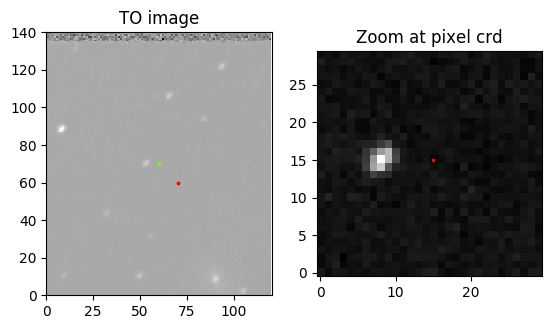

Pixel coordinates: [[ 60.01831403  60.00690441]]


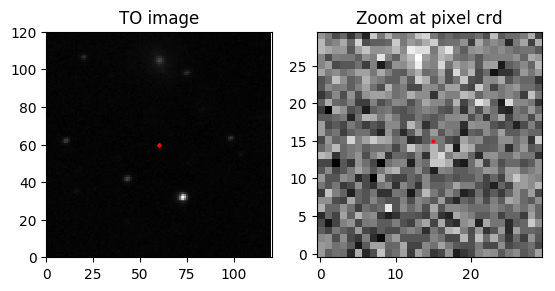

Pixel coordinates: [[ 60.02093936  68.00632995]]


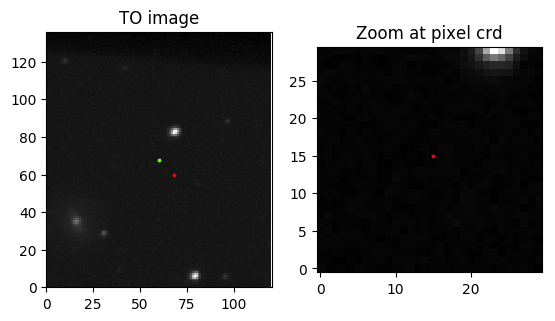

Pixel coordinates: [[ 60.02092376  68.00632741]]


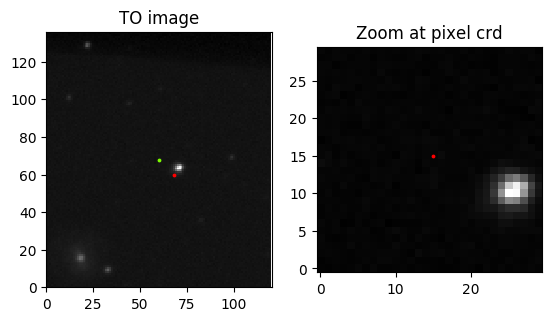

Pixel coordinates: [[ 60.02094194  68.0063371 ]]


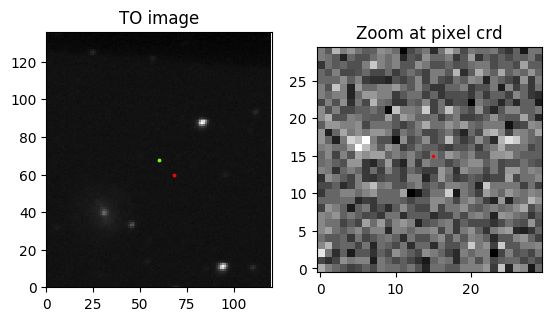

Pixel coordinates: [[ 60.02093779  68.00634001]]


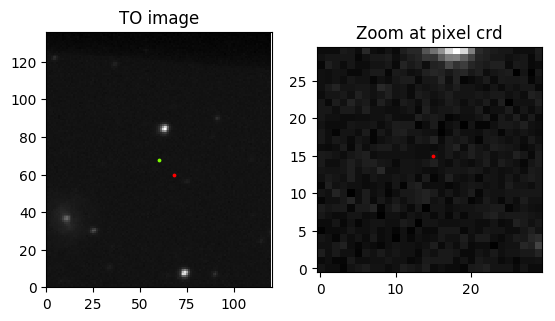

Pixel coordinates: [[ 59.97892207  68.00627301]]


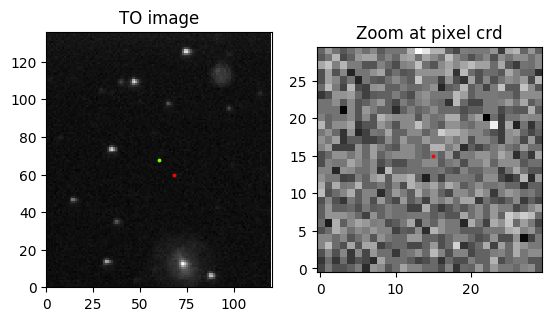

Pixel coordinates: [[ 59.98147802  60.00693049]]


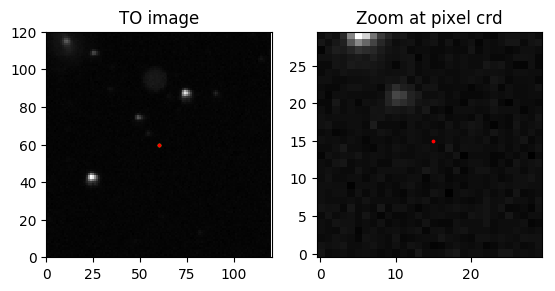

Pixel coordinates: [[ 59.97885565  68.00636796]]


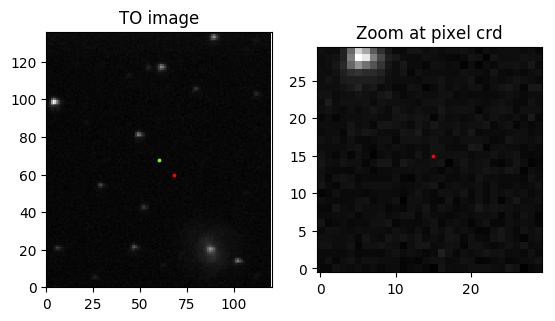

Pixel coordinates: [[ 59.97879839  68.00646318]]


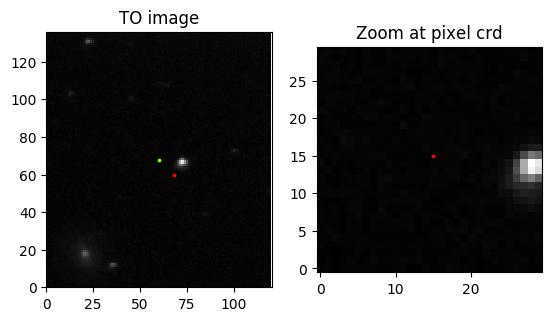

Pixel coordinates: [[ 60.01829648  60.00688918]]


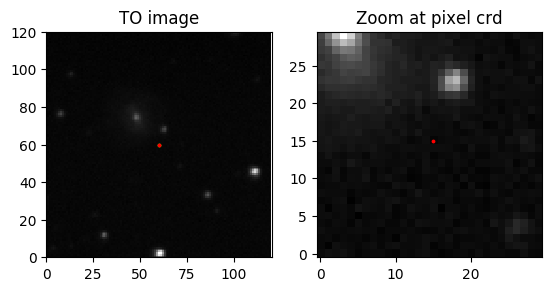

Pixel coordinates: [[ 60.01831142  60.00689943]]


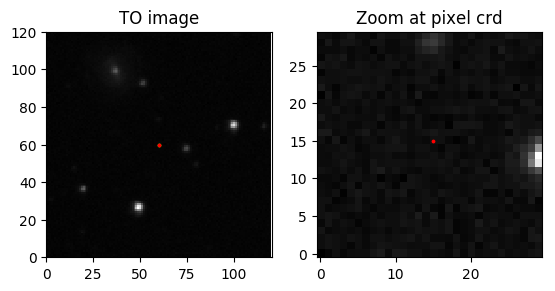

Pixel coordinates: [[ 60.01830886  60.00690127]]


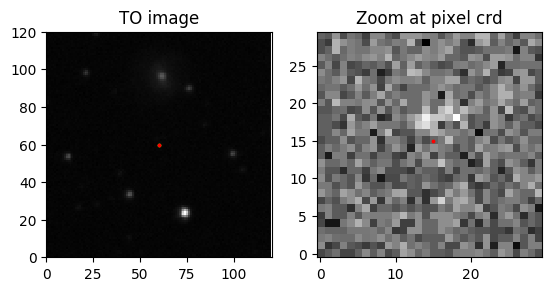

Pixel coordinates: [[ 60.02109307  68.00617333]]


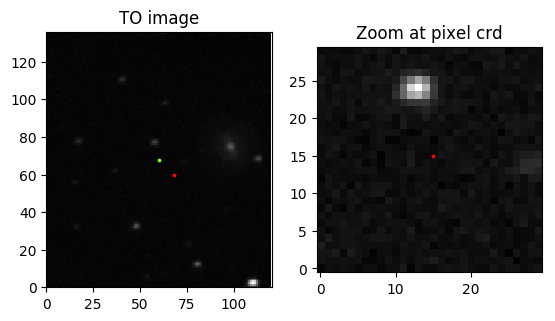

Pixel coordinates: [[ 60.02108038  68.00616883]]


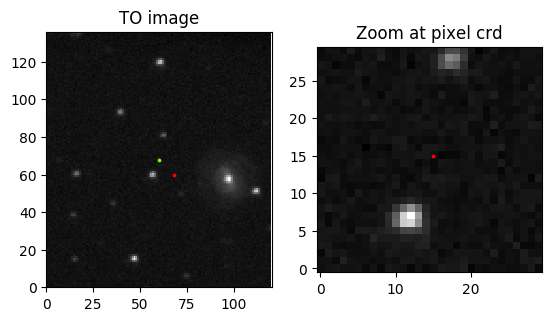

Pixel coordinates: [[ 60.02109775  68.00617688]]


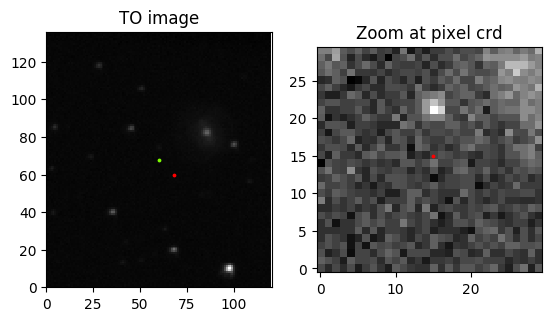

Pixel coordinates: [[ 60.02109734  68.00617732]]


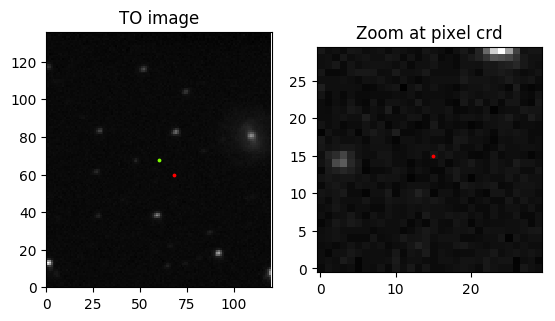

Pixel coordinates: [[ 60.0184098   60.00675704]]


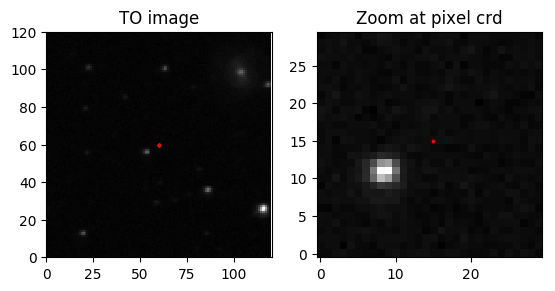

Pixel coordinates: [[ 60.01839787  60.00675314]]


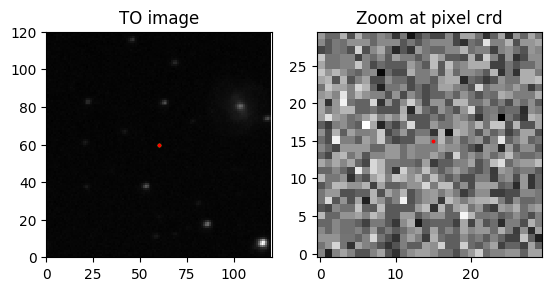

Pixel coordinates: [[ 60.01841437  60.00676251]]


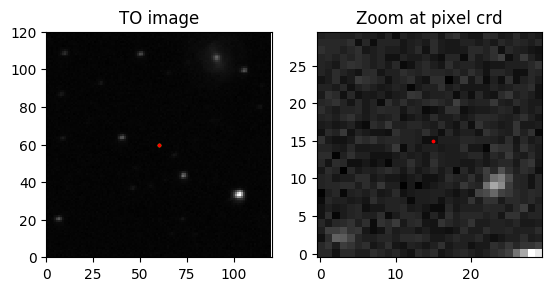

Pixel coordinates: [[ 60.01841242  60.00676328]]


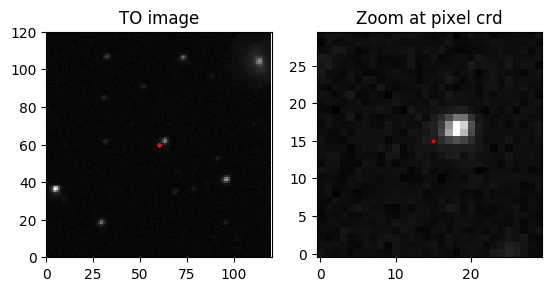

Pixel coordinates: [[ 60.01839665  60.00691495]]


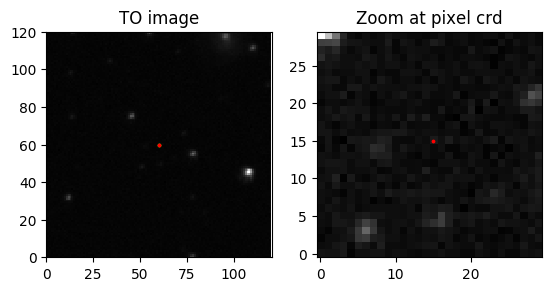

Pixel coordinates: [[ 60.02100634  68.00635653]]


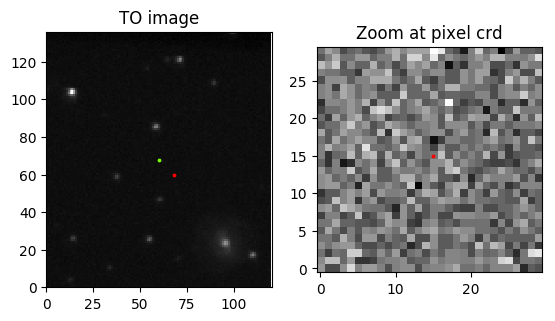

Pixel coordinates: [[ 60.02102239  68.0063656 ]]


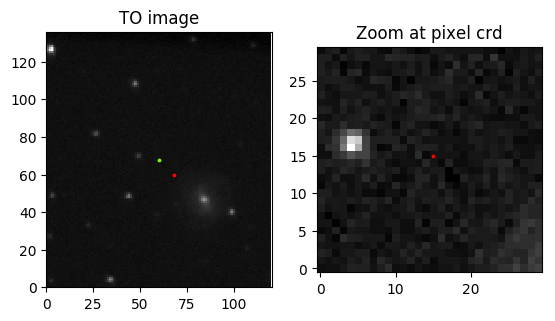

Pixel coordinates: [[ 60.02101807  68.0063673 ]]


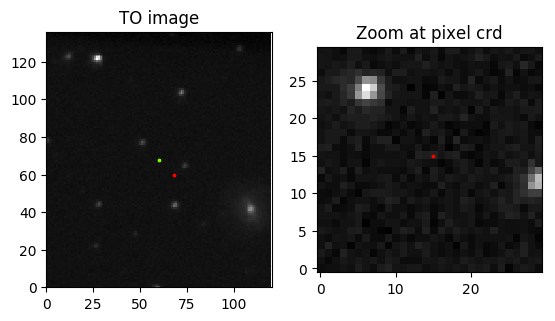

Pixel coordinates: [[ 60.01838844  60.00688844]]


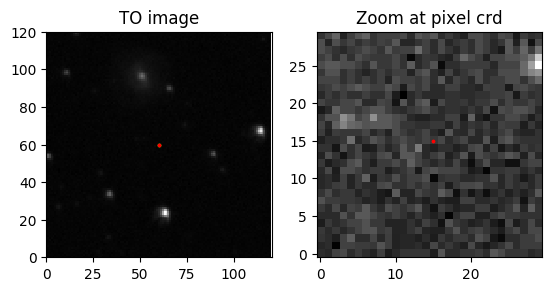

Pixel coordinates: [[ 60.01840396  60.00689849]]


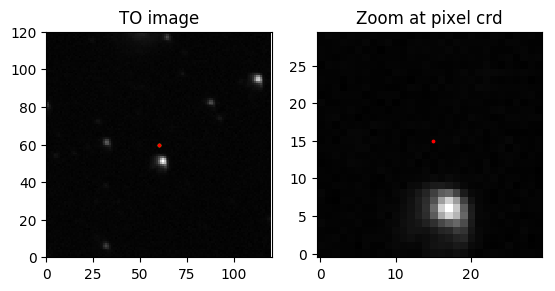

Pixel coordinates: [[ 60.02100441  68.00633288]]


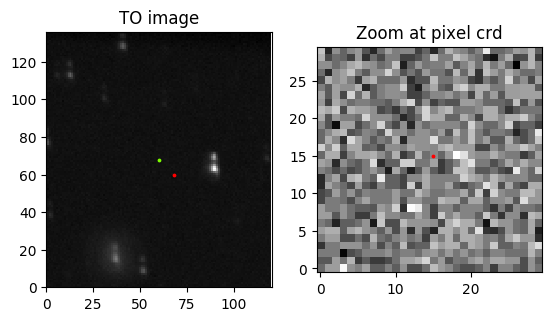

Pixel coordinates: [[ 60.02101139  68.00633684]]


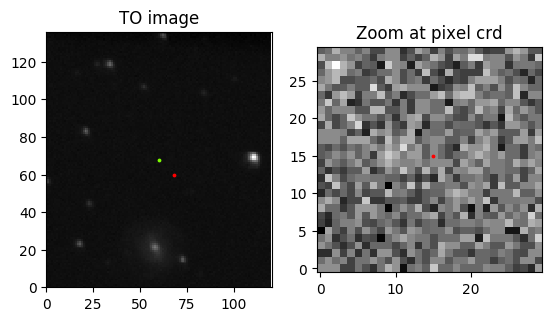

Pixel coordinates: [[ 60.01836364  60.00688885]]


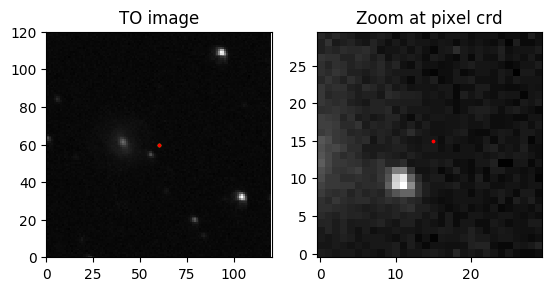

Pixel coordinates: [[ 60.01834997  60.0068851 ]]


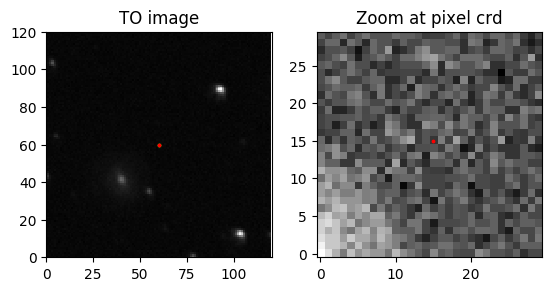

Pixel coordinates: [[ 60.0183642   60.00689387]]


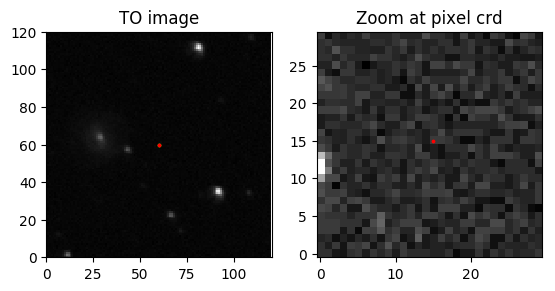

Pixel coordinates: [[ 60.01836129  60.00689529]]


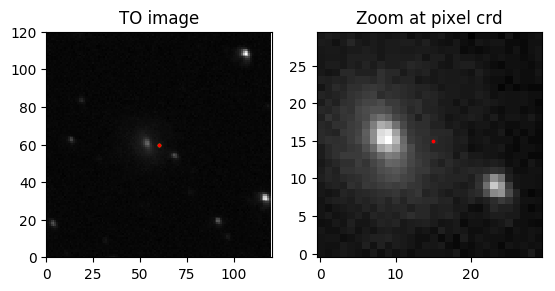

Pixel coordinates: [[ 60.01838522  60.0069049 ]]


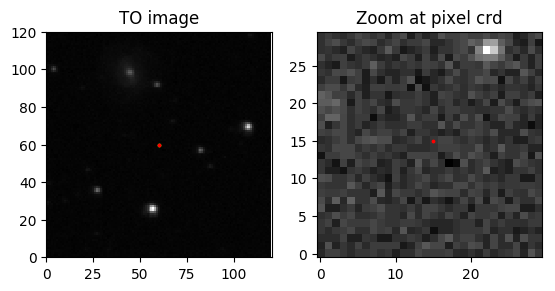

Pixel coordinates: [[ 60.018374    60.00690115]]


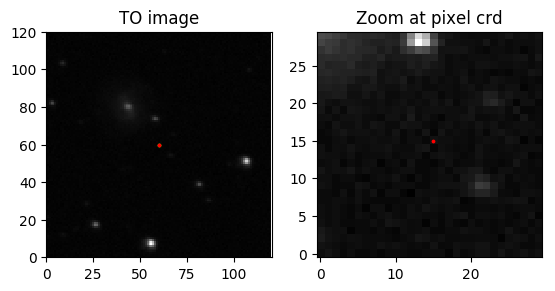

Pixel coordinates: [[ 60.01838874  60.00690981]]


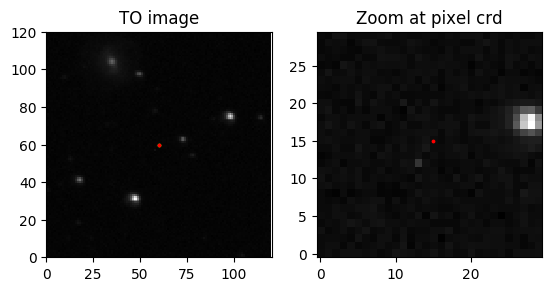

Pixel coordinates: [[ 60.0183863   60.00691113]]


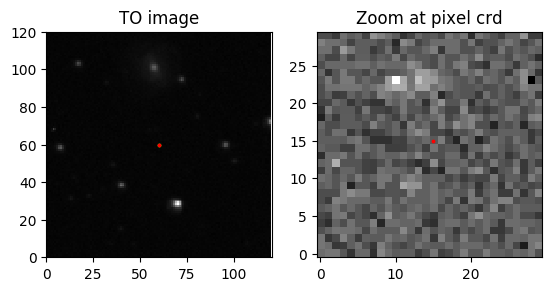

Pixel coordinates: [[ 59.98348292  60.00922927]]


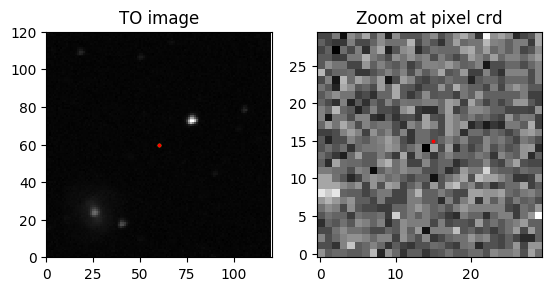

Pixel coordinates: [[ 59.9834826   60.00922134]]


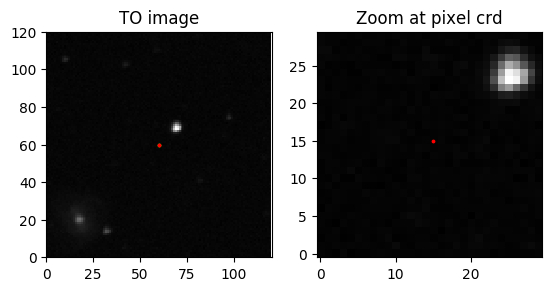

Pixel coordinates: [[ 59.98348663  60.00921461]]


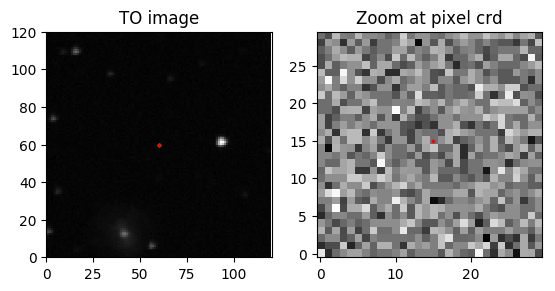

Pixel coordinates: [[ 60.02105739  68.00634578]]


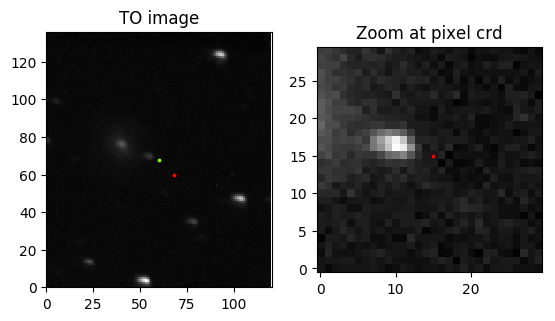

Pixel coordinates: [[ 60.02101788  68.00635547]]


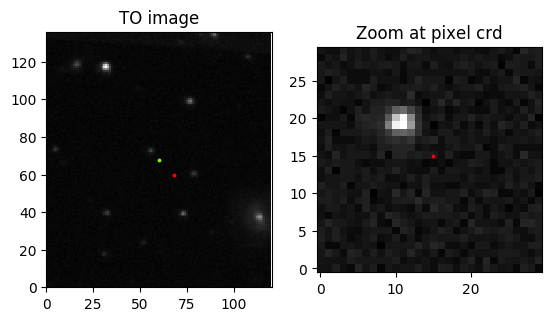

Pixel coordinates: [[ 60.01840042  60.00691787]]


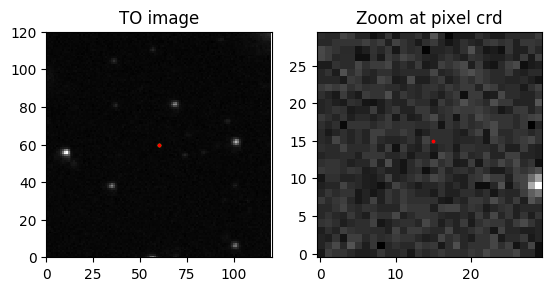

Pixel coordinates: [[ 60.01834016  60.00682923]]


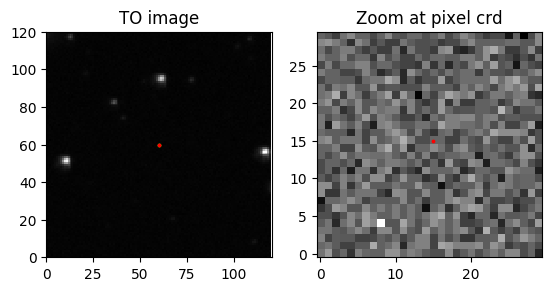

Pixel coordinates: [[ 60.02101587  68.00636354]]


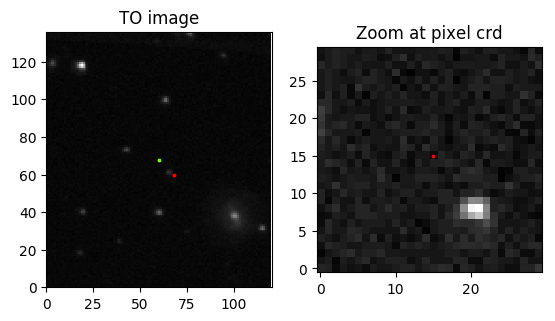

Pixel coordinates: [[ 60.02095237  68.00626575]]


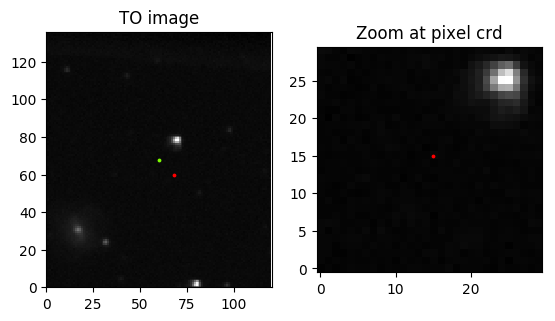

Pixel coordinates: [[ 60.01840578  60.00690327]]


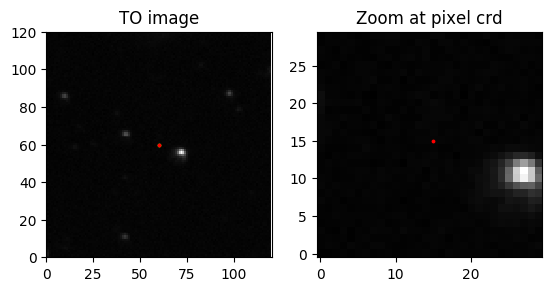

Pixel coordinates: [[ 60.02099989  68.00633318]]


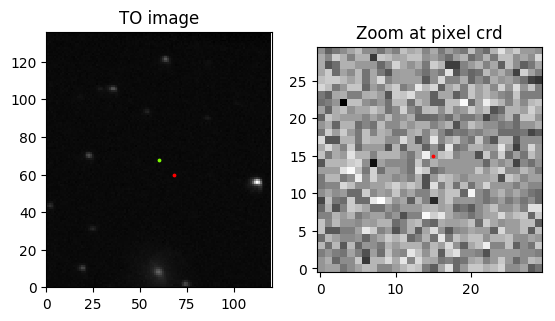

Pixel coordinates: [[ 60.0183866   60.00689687]]


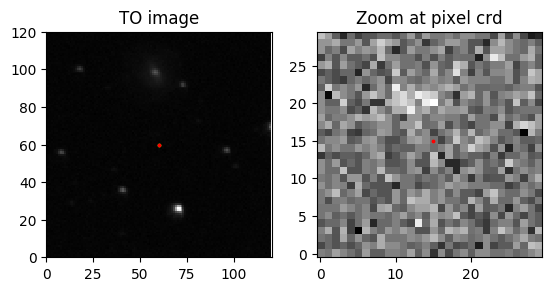

Pixel coordinates: [[ 60.02100299  68.00633916]]


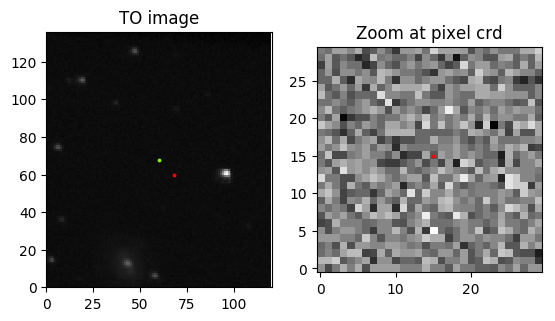

Pixel coordinates: [[ 60.01840215  60.00691035]]


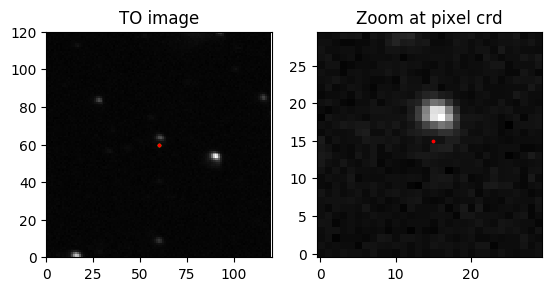

Pixel coordinates: [[ 60.02099624  68.00634126]]


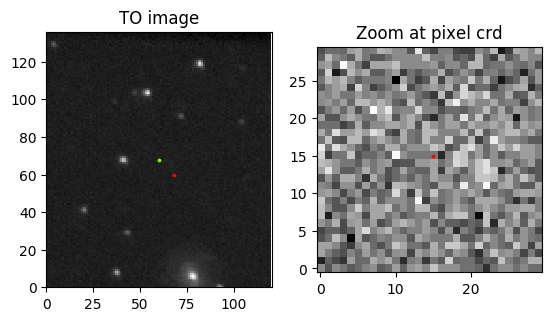

Pixel coordinates: [[ 60.02103529  68.00632616]]


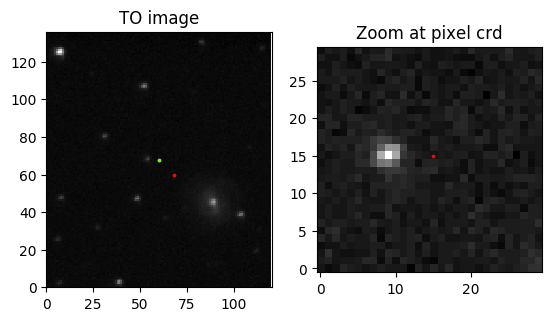

Pixel coordinates: [[ 60.02101193  68.00631849]]


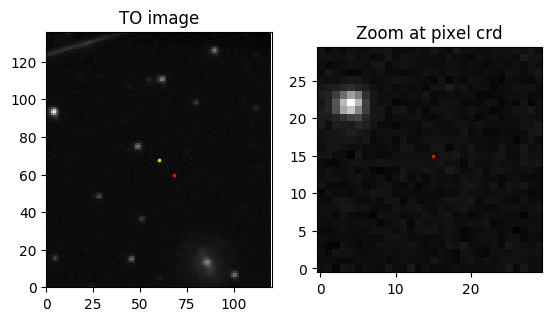

Pixel coordinates: [[ 60.02103517  68.00632946]]


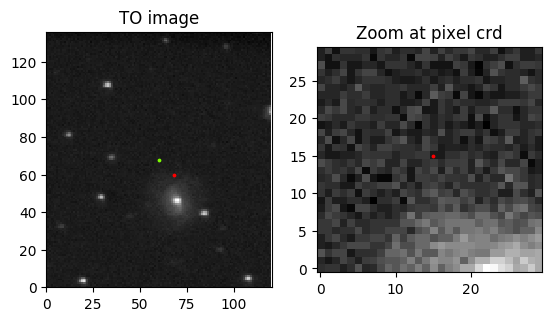

Pixel coordinates: [[ 60.02102721  68.00632942]]


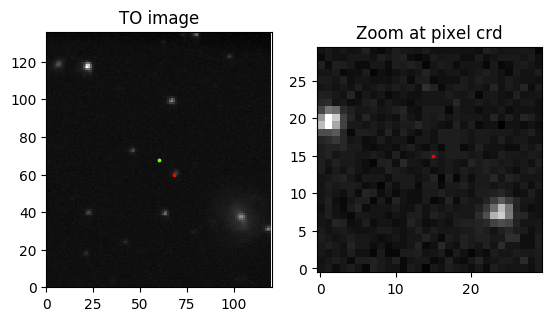

Pixel coordinates: [[ 60.01844572  60.00720998]]


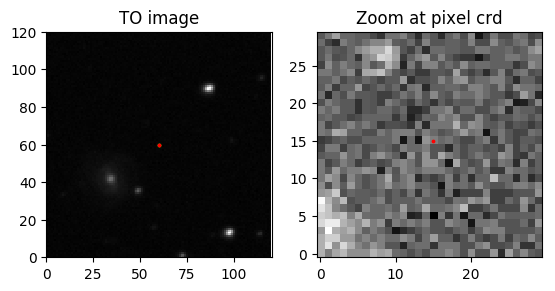

Pixel coordinates: [[ 60.01843306  60.00730452]]


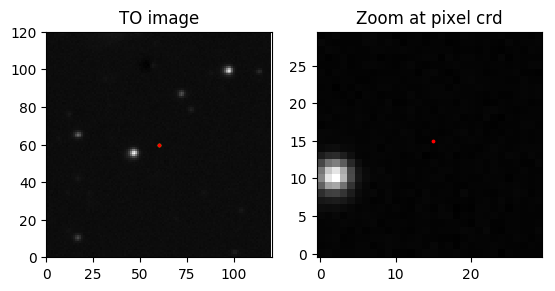

Pixel coordinates: [[ 60.01842121  60.00720446]]


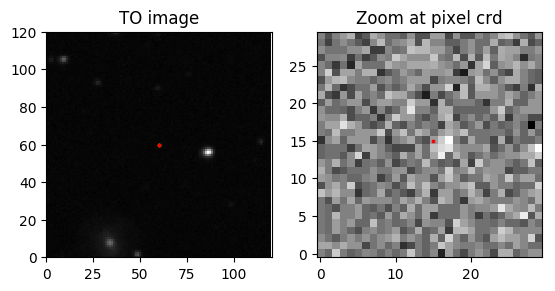

Pixel coordinates: [[ 60.01844152  60.00721764]]


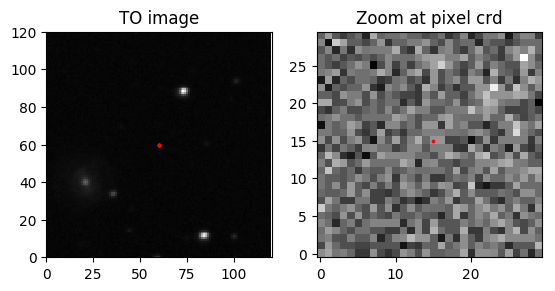

Pixel coordinates: [[ 60.01843544  60.00721919]]


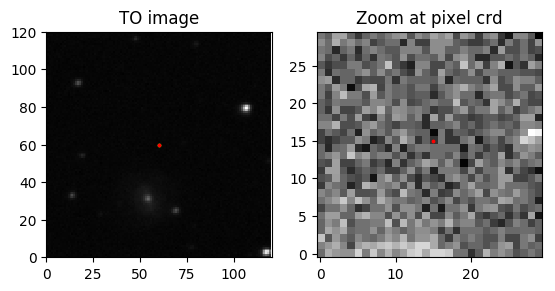

Pixel coordinates: [[ 60.02099603  68.00641339]]


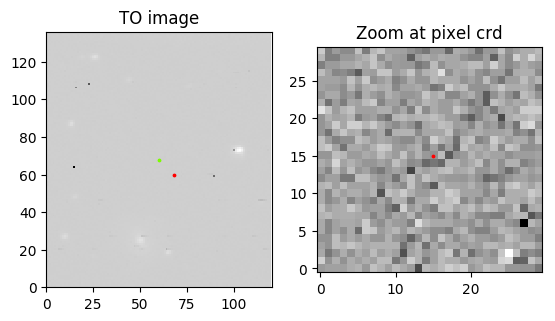

Pixel coordinates: [[ 60.01838914  60.00696795]]


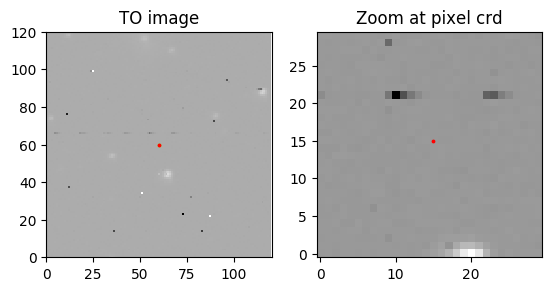

Pixel coordinates: [[ 60.02099791  68.00641962]]


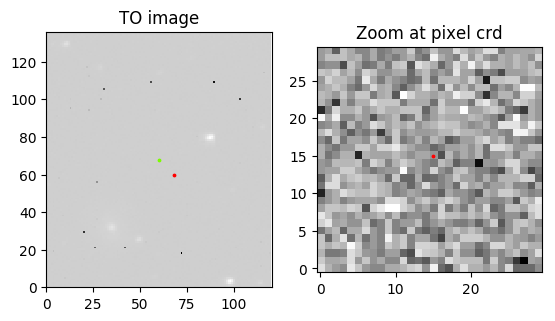

Pixel coordinates: [[ 60.02099461  68.00641943]]


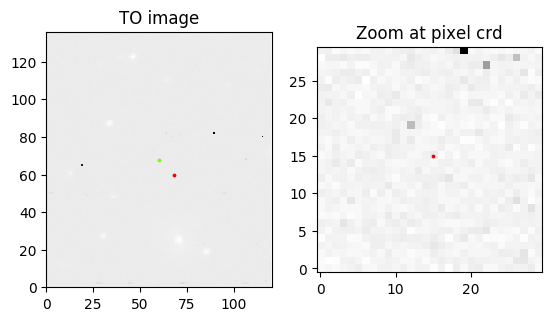

Pixel coordinates: [[ 59.98344323  60.0091178 ]]


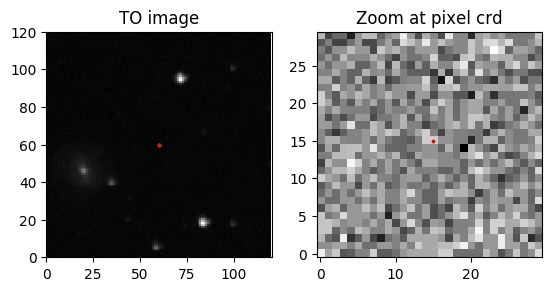

Pixel coordinates: [[ 59.98346022  60.00910904]]


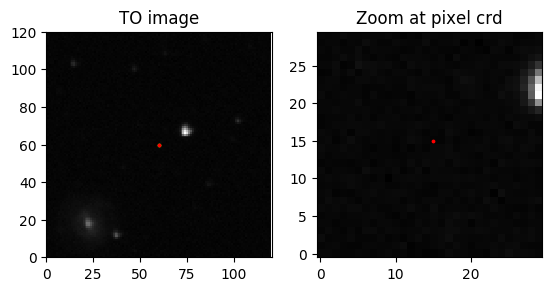

Pixel coordinates: [[ 59.9835007   60.00903378]]


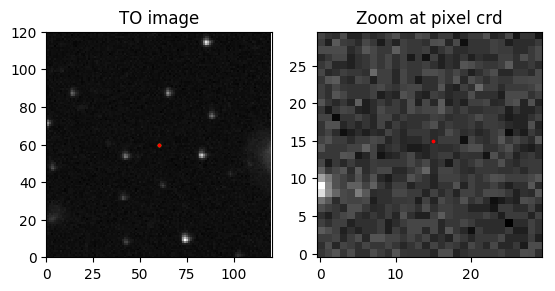

Pixel coordinates: [[ 59.98343767  60.0091185 ]]


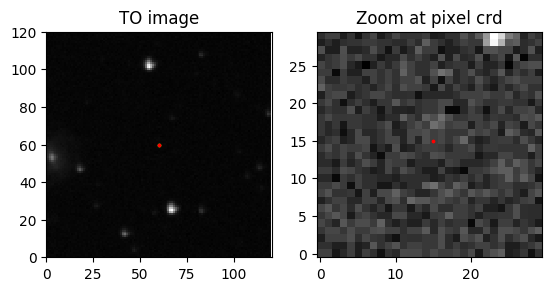

Pixel coordinates: [[ 59.98344086  60.00911626]]


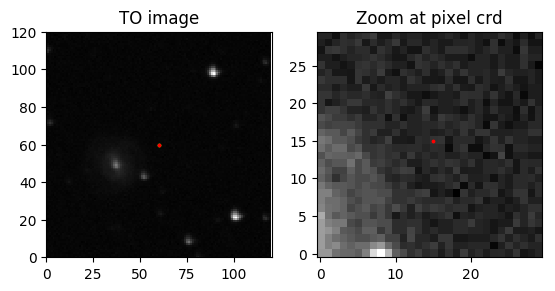

Pixel coordinates: [[ 75.02244252  60.0115496 ]]


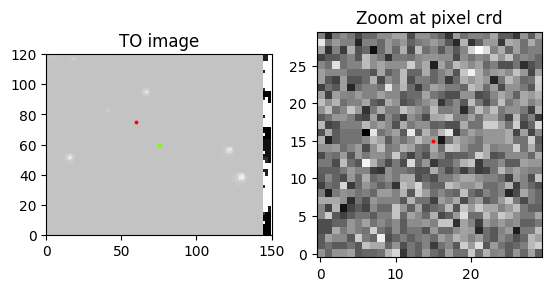

Pixel coordinates: [[ 75.0224228   60.01154241]]


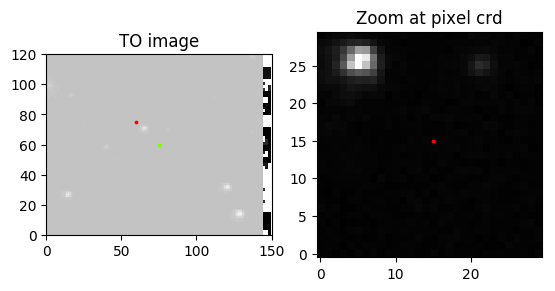

Pixel coordinates: [[ 60.02093706  68.00629907]]


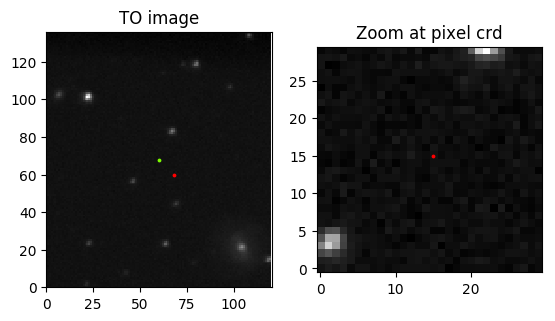

Pixel coordinates: [[ 75.02568804  68.01091507]]


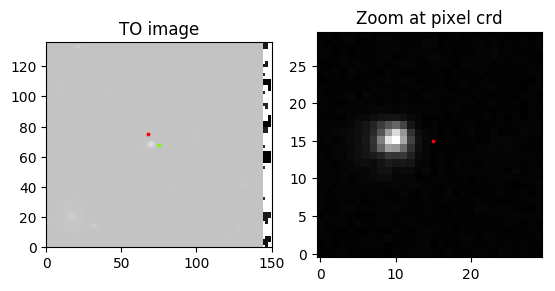

Pixel coordinates: [[ 60.02102192  68.00641405]]


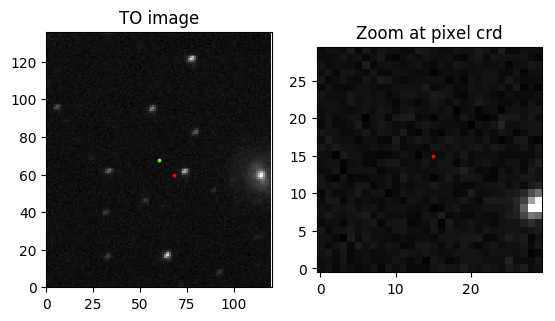

Pixel coordinates: [[ 60.02099816  68.00640578]]


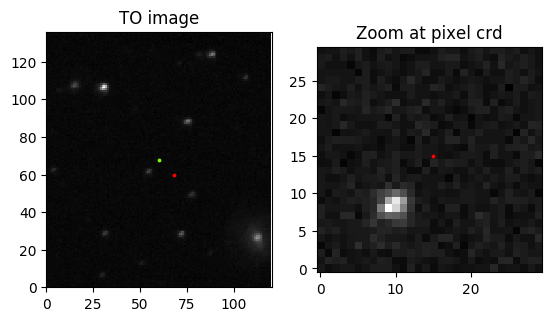

Pixel coordinates: [[ 60.02101899  68.0064172 ]]


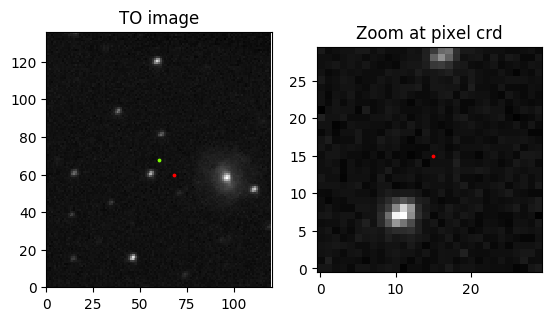

Pixel coordinates: [[ 60.02095527  68.00631701]]


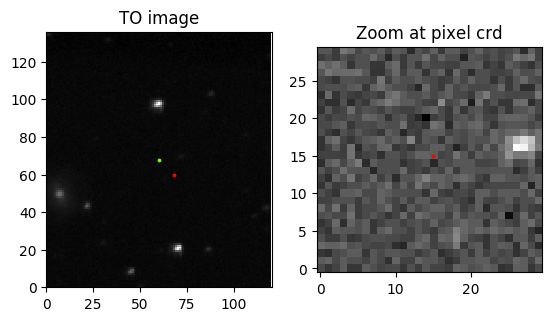

Pixel coordinates: [[ 60.02105544  68.00642911]]


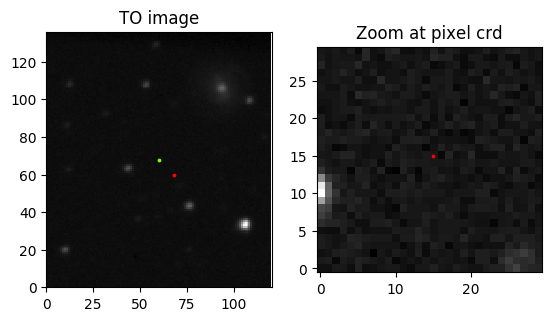

Pixel coordinates: [[ 60.02103018  68.00642236]]


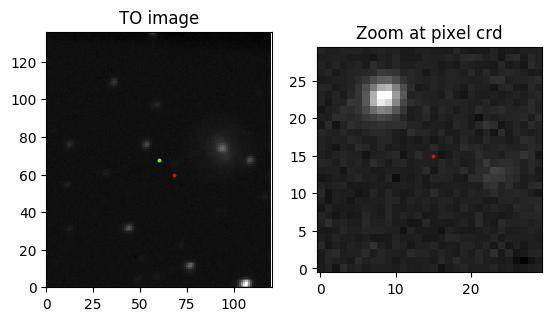

Pixel coordinates: [[ 60.02104966  68.00643212]]


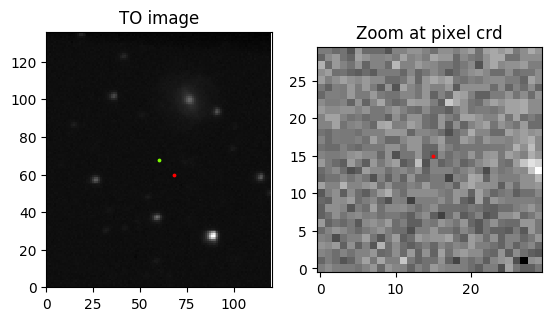

Pixel coordinates: [[ 60.02104061  68.00643302]]


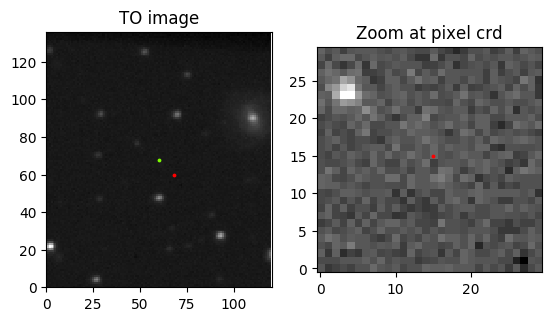

Pixel coordinates: [[ 60.02106906  68.00650809]]


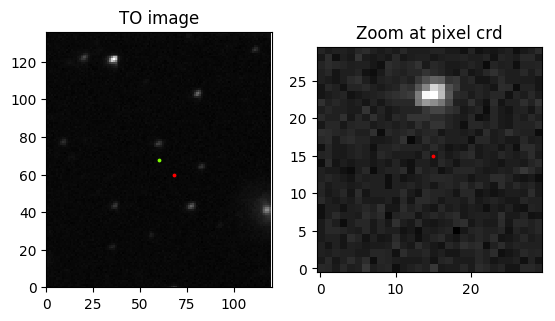

Pixel coordinates: [[ 60.02101147  68.00640792]]


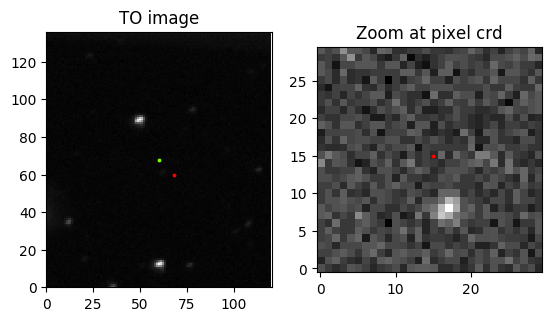

Pixel coordinates: [[ 60.021042    68.00650193]]


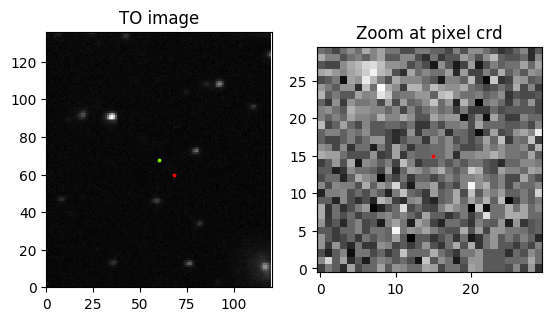

Pixel coordinates: [[ 60.02098495  68.00640191]]


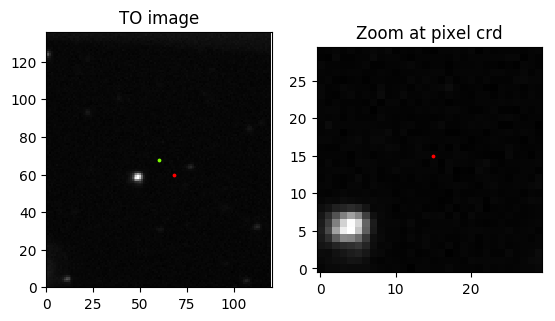

Pixel coordinates: [[ 60.02106976  68.00651273]]


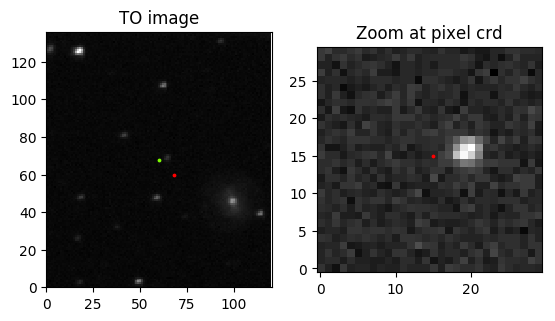

Pixel coordinates: [[ 60.02100651  68.00641294]]


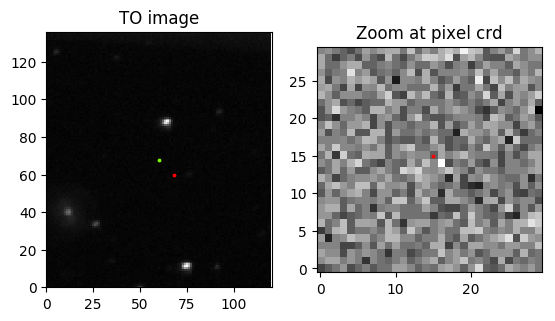

Pixel coordinates: [[ 60.01840446  60.00690568]]


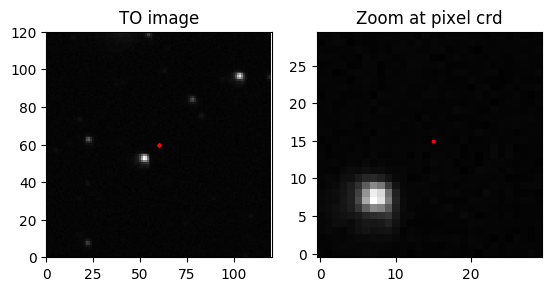

Pixel coordinates: [[ 60.02099787  68.00633603]]


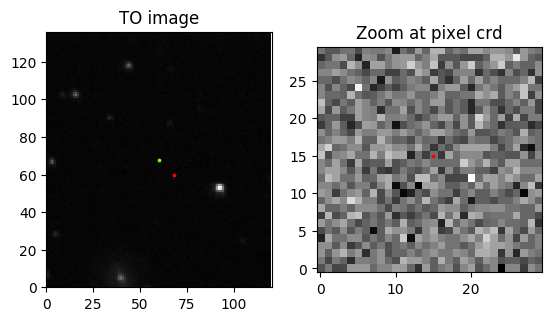

Pixel coordinates: [[ 60.0183901   60.00690133]]


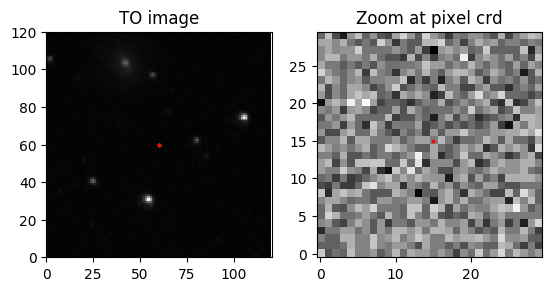

Pixel coordinates: [[ 60.01840274  60.00691018]]


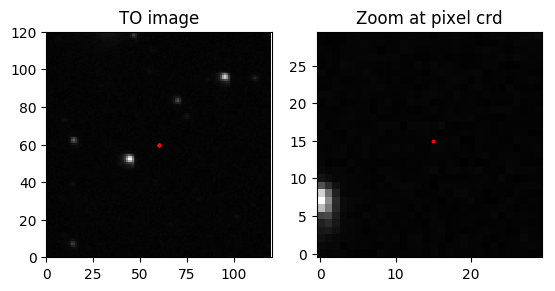

Pixel coordinates: [[ 60.01839919  60.00691096]]


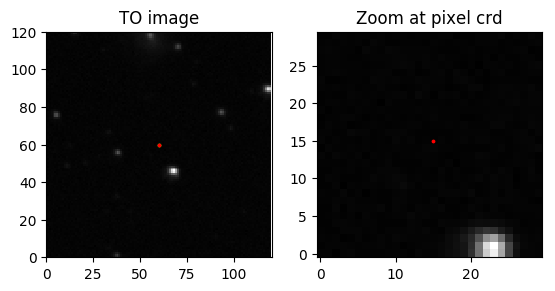

In [12]:
#Extract the name of the .fits file from the DF
#read pkl file if it is already saved
out_dir = '/home/oem/Documentos/Astronomy/CRTS/Data/'
object_class = 'CV'
file_name = 'first_object.zip'
complete_path = out_dir + object_class + '/'
path_to_file = complete_path + file_name[0:-4] + '/'
df_per_object = pd.read_pickle(path_to_file + 'first_object.pkl')
df_per_object = df_per_object.sort_values('FILENAME')
fig = plt.figure()
for index, row in df_per_object.iterrows():
    file_name_from_df = row['FILENAME']
    ra_crd_from_df = float(row['CENTER_RA'])
    dec_crd_from_df = float(row['CENTER_DEC'])
    hdu_list = fits.open(path_to_file + file_name_from_df)
    image_data = hdu_list[0].data
    #world2pix
    w = wcs.WCS(hdu_list[0].header)
    ra_dec_crd = w.wcs.crval
    #worldcrd = np.array([[ra_dec_crd[0], ra_dec_crd[1]]]) #crds from metadata
    worldcrd = np.array([[ra_crd_from_df, dec_crd_from_df]]) 
    pixcrd = w.wcs_world2pix(worldcrd, 1)
    print('Pixel coordinates:',pixcrd)
    #plot the image and ra/dec crds
    f, (ax1, ax2) = plt.subplots(1, 2,)#,  gridspec_kw = {'width_ratios':[3, 1]})
    ax1.imshow(image_data, cmap='gray',origin='lower', norm=LogNorm())
    ax1.scatter(pixcrd[0,0], pixcrd[0,1],color='lawngreen',s=3)
    ax1.scatter((pixcrd[0,1]), (pixcrd[0,0]),color='r',s=3)
    ymin =0
    xmin = 0
    ymax_o, xmax_o = np.shape(image_data)
    ax1.set_ylim([ymin,ymax_o])
    ax1.set_xlim([xmin,xmax_o])
    ax1.set_title('TO image')
    #extract a vicinity around the pixelcrd
    ww = 15
    image_sub_sampled = image_data[int(pixcrd[0,1])-ww:int(pixcrd[0,1])+ww, int(pixcrd[0,0])-ww:int(pixcrd[0,0])+ww]
    ax2.imshow(image_sub_sampled, cmap='gray',origin='lower', norm=LogNorm())
    ymin =0
    xmin = 0
    ymax, xmax = np.shape(image_sub_sampled)
    ax2.scatter(int(ymax/2), int(xmax/2) ,color='r',s=3)
  
    #ax2.set_ylim([ymin,ymax])
    #ax2.set_xlim([xmin,xmax])
    ax2.set_title('Zoom at pixel crd')
    plt.show()
    #print(file_name_from_df)

In [7]:
df_per_object.head()

CENTER_DEC      CENTER_RA                                 FILENAME  \
0   -22.702660072  332.622014676  02_09SEP24_S23110_0003_cutout_3132.fits   
1  -22.7046494294   332.62343301  01_11OCT17_S23110_0002_cutout_2931.fits   
2  -22.6957996987  332.605028823  01_05SEP26_S23109_0002_cutout_0432.fits   
3  -22.6716334244  332.630896302  01_09SEP16_S23110_0002_cutout_3132.fits   
4  -22.6849051517  332.625899821  01_06NOV17_S23110_0003_cutout_3232.fits   

     OBS-DATE  
0  2009-09-24  
1  2011-10-17  
2  2005-09-26  
3  2009-09-16  
4  2006-11-17

In [8]:
for index, row in df_per_object.iterrows():
    file_name_from_df = row['FILENAME']
    print(file_name_from_df)

02_09SEP24_S23110_0003_cutout_3132.fits
01_11OCT17_S23110_0002_cutout_2931.fits
01_05SEP26_S23109_0002_cutout_0432.fits
01_09SEP16_S23110_0002_cutout_3132.fits
01_06NOV17_S23110_0003_cutout_3232.fits
01_09SEP16_S23110_0003_cutout_3132.fits
01_12AUG24_S23110_0001_cutout_3133.fits
01_12AUG24_S23110_0003_cutout_3133.fits
01_12JUN21_S21112_0001_cutout_0600.fits
01_12SEP20_S23110_0004_cutout_3133.fits
01_12JUN21_S21112_0002_cutout_0600.fits
01_10NOV02_S23110_0004_cutout_3233.fits
01_09SEP19_S21112_0003_cutout_0600.fits
01_05OCT10_S23110_0001_cutout_3233.fits
01_05OCT10_S23110_0004_cutout_3233.fits
01_09SEP24_S23110_0001_cutout_3133.fits
01_12JUN21_S21112_0004_cutout_0600.fits
01_09AUG29_S23110_0001_cutout_3132.fits
01_11OCT17_S23110_0003_cutout_2932.fits
01_09AUG29_S23110_0002_cutout_3132.fits
01_09SEP19_S21112_0001_cutout_0600.fits
01_05OCT10_S23110_0003_cutout_3233.fits
01_11OCT17_S23110_0001_cutout_2932.fits
01_09AUG29_S23110_0003_cutout_3132.fits
01_12OCT10_S23110_0004_cutout_3233.fits
